In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

In [2]:
LENGTH = 1000  # 每一个样本由1000个
def sample_data(size,length=100):
    """
    生成均值为4方差为1.5的正态分布随机数据，并排序
    """
    data=[]
    for _ in range(size):
        datas = sorted(np.random.normal(4,1.5,length))
        data.append(datas)
    return np.array(data)

def random_noise(size,length=100):
    """
    生成随机噪声
    """
    data=[]
    for _ in range(size):
        x = np.random.random(length)
        data.append(x)
        
    return np.array(data)
def preprocess_data(x):
    """
    计算每一组数据的均值和方差
    """
    return [[np.mean(data),np.std(data)] for data in x]


In [3]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32,shape=[None,2],name="feature") #[mean,std]
y = tf.placeholder(tf.float32,shape=[None,1],name="label")
in_size = LENGTH
out_size = LENGTH
###########构造生成器网络结构 G##########
#第一层
z = tf.placeholder(tf.float32,shape=[None,LENGTH],name="noise") #随机值噪音
Weights = tf.Variable(tf.random_normal([in_size,32]))
biases = tf.Variable(tf.zeros([1,32]) + 0.1)
G_output = tf.matmul(z,Weights) + biases
G_output = tf.nn.relu(G_output)
#第二层
Weights2 = tf.Variable(tf.random_normal([32,32]))
biases2 = tf.Variable(tf.zeros([1,32]) + 0.1)
G_output2 = tf.nn.sigmoid(tf.matmul(G_output,Weights2) + biases2)
#第三层
Weights3 = tf.Variable(tf.random_normal([32,out_size]))
biases3 = tf.Variable(tf.zeros([1,out_size]) + 0.1)
G_output3 = tf.matmul(G_output2,Weights3) + biases3

#G 的参数列表
G_params = [Weights,biases,Weights2,biases2,Weights3,biases3]

##################判别器网络结构 （预训练的D）
#第一层
dWeights = tf.Variable(tf.random_normal([2,32]),name="D_W")
dbiases = tf.Variable(tf.zeros([1,32]) + 0.1,name = "D_b")
D_output = tf.nn.relu(tf.matmul(x,dWeights) + dbiases)
#第二层
dWeights2 = tf.Variable(tf.random_normal([32,32]),name="D_W2")
dbiases2 = tf.Variable(tf.zeros([1,32]) + 0.1,name="D_b2")
D_output2 = tf.nn.sigmoid(tf.matmul(D_output,dWeights2) + dbiases2)
#第三层
dWeights3 = tf.Variable(tf.random_normal([32,1]),name="D_W3")
dbiases3 = tf.Variable(tf.zeros([1,1]) + 0.1,name="D_b3")
D_output3 = tf.nn.sigmoid(tf.matmul(D_output2,dWeights3) + dbiases3)
# D的参数列表
D_params = [dWeights,dbiases,dWeights2,dbiases2,dWeights3,dbiases3]

#####GAN的结构###########
#先求出生成模型G中各行的平均值和方差
mean = tf.reduce_mean(G_output3,axis=1) #行向量上
mean_t= tf.transpose(tf.expand_dims(mean,axis=0)) #0轴上扩维并装置
std = tf.sqrt(tf.reduce_mean(tf.square(G_output3 - mean_t),axis=1))
std_t = tf.transpose(tf.expand_dims(std,axis=0))
data = tf.concat([mean_t,std_t],axis=1) # 在第一维上进行矩阵连接

###GAN中的判别模型D
gan_Weights = tf.Variable(tf.random_normal([2,32]),name="gan_W")
gan_biases = tf.Variable(tf.zeros([1,32]) + 0.1,name="gan_b")
gan_output = tf.nn.relu(tf.matmul(data,gan_Weights) + gan_biases)
##GAN中第二层
gan_Weights2 = tf.Variable(tf.random_normal([32,32]),name="gan_W2")
gan_biases2 = tf.Variable(tf.zeros([1,32]) + 0.1,name="gan_b2")
gan_output2 = tf.nn.sigmoid(tf.matmul(gan_output,gan_Weights2) + gan_biases)
##第三层
gan_Weights3 = tf.Variable(tf.random_normal([32,1]),name="gan_W3")
gan_biases3 = tf.Variable(tf.zeros([1,1]) + 0.1,name="gan_b3")
gan_output3 = tf.nn.sigmoid(tf.matmul(gan_output2,gan_Weights3) + gan_biases3)

gan_D_params = [gan_Weights,gan_biases,gan_Weights2,gan_biases2,gan_Weights3,gan_biases3]




In [4]:
##定义损失函数
#D的二分类交叉熵
d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_output3,labels=y))
#gan 的二分类交叉熵
gan_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_output3,labels=y))
#定义优化器
d_optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(
    loss=d_loss,
    global_step=tf.Variable(0),
    var_list=D_params
)
gan_optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(
    loss=gan_loss,
    global_step=tf.Variable(0),
    var_list=G_params
)

In [5]:
d_loss_history = []
g_loss_history = []
epoch = 200
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #GAN 博弈开始
    print('begin train GAN....')
    for step in range(epoch):
        #先进行GAN中D的训练，即对生成样本的判断
        for _ in range(100):
            # 使用G生成一批样本
            real = sample_data(100,length=LENGTH)
            noise = random_noise(100,length=LENGTH)
            generate = sess.run(G_output3,feed_dict={z:noise}) #生成样本噪声
            X = list(real) + list(generate)
            X = preprocess_data(X)
            Y = [[1] for _ in range(len(real))] + [[0] for _ in range(len(generate))]
            #预训练的判别器模型D损失
            d_loss_value,_ = sess.run([d_loss,d_optimizer],feed_dict={x:X,y:Y}) # 训练判别网络
            d_loss_history.append(d_loss_value)
        
        #获取预训练模型D中的参数
        dp_value = sess.run(D_params)
        #将参数移到GAN中判别模型D中
        for i,v in enumerate(gan_D_params):
            sess.run(v.assign(dp_value[i]))
        for _ in range(100):
            noise = random_noise(100,length=LENGTH)
            gan_loss_value,_ = sess.run([gan_loss,gan_optimizer],feed_dict={
                z:noise,
                y:[[1] for _ in range(len(noise))]  # 混肴为目标,不需要加入x，我们只是借助G，并不需要训练G
            })# 调整G，让GAN的误差减少
            g_loss_history.append(gan_loss_value)
        if step % 20 == 0 or step+1 == epoch:
            noise = random_noise(1,length=LENGTH)
            generate = sess.run(G_output3, feed_dict={
                z: noise
            })
            print("[%4d] GAN-d-loss: %.12f  GAN-g-loss: %.12f   generate-mean: %.4f   generate-std: %.4f" % (step,
                            d_loss_value, gan_loss_value,generate.mean() ,generate.std() ))
            

begin train GAN....
[   0] GAN-d-loss: 0.580556273460  GAN-g-loss: 0.585608661175   generate-mean: 0.2116   generate-std: 3.9548
[  20] GAN-d-loss: 0.513905823231  GAN-g-loss: 0.681111931801   generate-mean: 0.1123   generate-std: 3.7617
[  40] GAN-d-loss: 0.509921014309  GAN-g-loss: 0.686247587204   generate-mean: 0.1330   generate-std: 3.3142
[  60] GAN-d-loss: 0.508007943630  GAN-g-loss: 0.688097059727   generate-mean: 0.1367   generate-std: 3.4045
[  80] GAN-d-loss: 0.506953358650  GAN-g-loss: 0.689218282700   generate-mean: 0.2508   generate-std: 3.9265
[ 100] GAN-d-loss: 0.506333529949  GAN-g-loss: 0.689893126488   generate-mean: 0.2438   generate-std: 3.2991
[ 120] GAN-d-loss: 0.505889773369  GAN-g-loss: 0.690385222435   generate-mean: 0.2512   generate-std: 3.6774
[ 140] GAN-d-loss: 0.505571782589  GAN-g-loss: 0.690713405609   generate-mean: 0.3395   generate-std: 3.3813
[ 160] GAN-d-loss: 0.505317628384  GAN-g-loss: 0.690986454487   generate-mean: 0.1672   generate-std: 3.6617

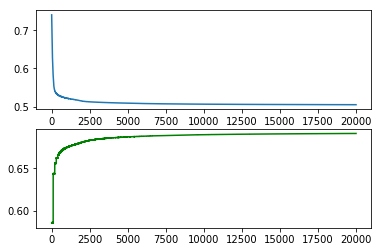

In [6]:
plt.subplot(211)
plt.plot(d_loss_history)
a = plt.subplot(212)
plt.plot(g_loss_history,c="g")

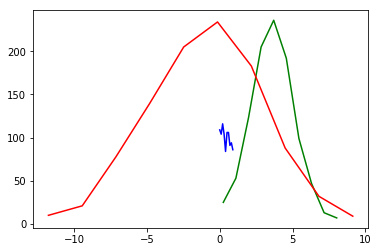

In [7]:
real = sample_data(1,length=LENGTH)
(data, bins) = np.histogram(real[0])
plt.plot(bins[:-1], data, c="g")


(data, bins) = np.histogram(noise[0])
plt.plot(bins[:-1], data, c="b")

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     generate = sess.run(G_output3, feed_dict={
#             z: noise
#     })
(data, bins) = np.histogram(generate[0])
plt.plot(bins[:-1], data, c="r")

In [8]:
#x - x * z + log(1 + exp(-x))

pre = np.array([1,0])
real = np.array([0,1])

pre-pre*real + np.log(1+np.exp(-pre))

array([1.31326169, 0.69314718])